<H1>Introduction</H1>
<article>
Below you will find a set of rather simple examples of analyzis of hedge funds based solely on monthly return series. The examples here are by no means complete. Many more types of analysis can be performed. 
</article>

In [6]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.api as sm 
%matplotlib inline
#Common Functions
import hfrisk as hf

<H2>Data Setup</H2>
<article>
We read data from csv file. The file contains return series for one fund as well as four market factors and a number of hedge fund benchmarks. The last column contains identification of market regime for each month. Market Regimes were calculated separately. See Regime Analysis notebook for more information.
</article>

In [2]:
marketdata = pd.read_csv('data/marketdata.csv',index_col='Data')
fund = marketdata['Fund']
cols = marketdata.columns
n_cols = len(cols)
""" last column is regime. The other columns are returns """
tsdata = marketdata[cols[0:n_cols-1]]
factors = tsdata.iloc[:, 1:5]

<H1>Analysis</H1>

In [4]:
#tsdata.set_index("Data",inplace=True)
fundStats = hf.basic_stats(tsdata).transpose()['Fund']
mu = fundStats['mu']
sigma = fundStats['std']


<B>Summary of Basic Statistics</B>
<P>
The fund produed an average annualized return of only 5.39% with annualized volatility of 26.98%. The fund has suffered a maximum drawdown of 47.51%. The fund's return distribution is postively skewed. The histogram of the fund's monthly returns is shown below. 

C:\Users\amati\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


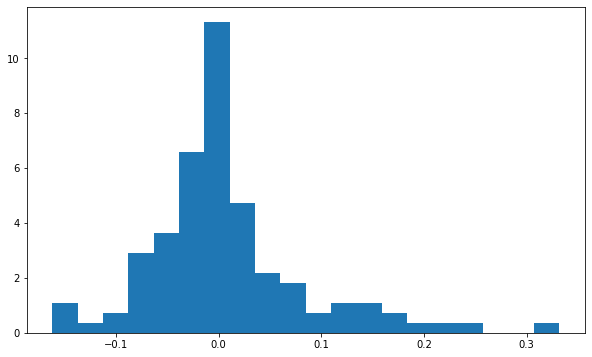

In [8]:
f, ax = plt.subplots(figsize=(10, 6))
n, bins, patches = pl.hist(fund, 20, normed=1, histtype='stepfilled')
y = norm.pdf(bins, mu, sigma)
pl.plot(bins, y, 'k--', linewidth=1.5, color='r')
pl.title ("Distribution of Monthly Returns")

<H2>Drawdown Analysis</H2>
The chart below shows "Underwater Curve" - the curve of the fund's drawdown compared to those of Equity benchmark. 

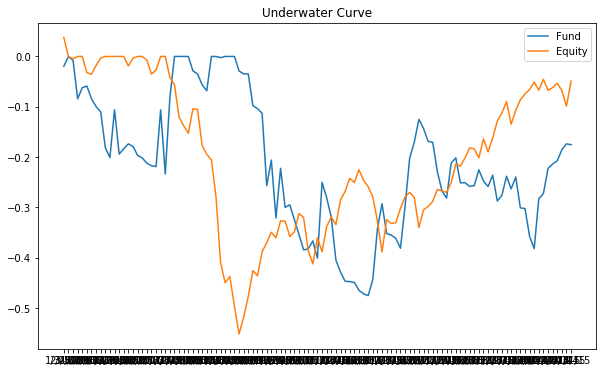

In [9]:
ddFund = hf.get_drawdowns(fund)
ddEquity = hf.get_drawdowns(tsdata['Equity'])
f, ax = plt.subplots(figsize=(10, 6))
plt.plot(ddFund,label='Fund')
plt.plot(ddEquity,label='Equity')
plt.legend()
plt.title("Underwater Curve")
NDrawdowns = ddFund

<h2>Perormance by Market Regime</h2>
<article>I developed proprietary model that separates market history into three distinct regimes 
based on the pattern of movements of main market indexes. 
We can use the output of the model to see how the fund would perform in various market environments</article>

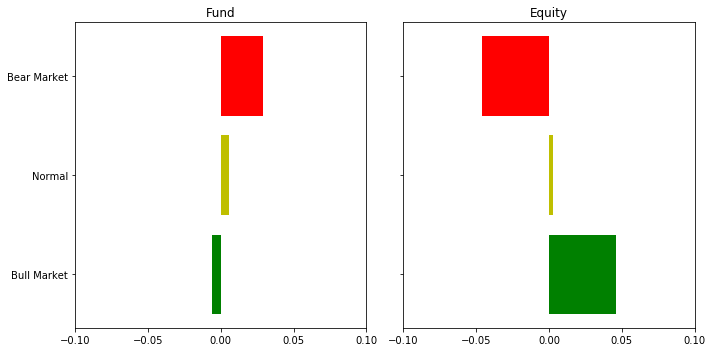

In [10]:
groupByRegime = marketdata.groupby(by='Regime')
avgByRegime = groupByRegime.mean()
f, ax = plt.subplots(figsize=(10,5))
plt.subplot(1,2,1)
plt.barh([1,2,3],avgByRegime['Fund'],color=['g','y','r'])

plt.title('Fund')
plt.yticks([1,2,3],['Bull Market','Normal','Bear Market'])
plt.xticks(np.arange(-0.1,0.15,0.05))
plt.subplot(1,2,2)
plt.barh([1,2,3],avgByRegime['Equity'],color=['g','y','r'])
plt.title('Equity')
plt.xticks(np.arange(-0.1,0.15,0.05))

plt.yticks([1,2,3],['','',''])
f.tight_layout()

<h2>Consistency of Returns</h2>
<article>
One way to evaluate consistency of returns is to perform two-sample Kolmogorov-Smirnov test and see if the return distribution is consistent before and after some time period cutoff. For simplicity of demo I just divide the time periods in half
</article>




Distribution is consistent with 97.89% certainty


C:\Users\amati\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.


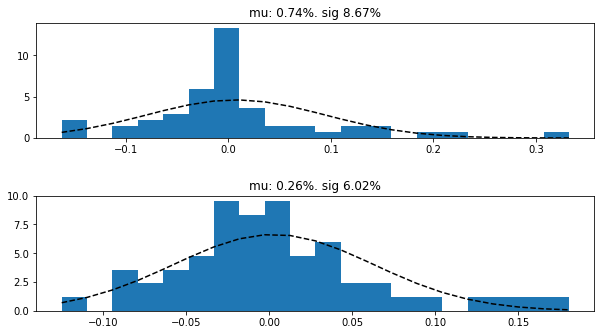

In [12]:
fund = marketdata['Fund']
T = len(fund)
T2 = int(T * 0.5)
fundrets = fund.values
fund_1 = fundrets[0:T2]
fund_2 = fundrets[T2+1:]
from scipy.stats import ks_2samp
ks,pval = ks_2samp(fund_1,fund_2)
if (pval >= 0.95):
    print (str.format("Distribution is consistent with {0:0.2%} certainty", pval ))
else:
    print (str.format("Distribution is not consistent. p-value is only {0:0.2%}",pval))

Times = [fund_1,fund_2]
f, ax = plt.subplots(figsize=(10, 5))
f.subplots_adjust(wspace=0.25, hspace=0.50, top=0.85, bottom=0.05)
for i in range(1,3):
    plt.subplot(2,1,i)
    Ti = Times[i-1]
    mu = np.mean(Ti)
    sigma = np.std(Ti)
    n, bins, patches = pl.hist(Ti, 20, normed=1, histtype='stepfilled')
    y = norm.pdf(bins, mu, sigma)
    pl.plot(bins, y, 'k--', linewidth=1.5)
    plt.title (str.format("mu: {0:0.02%}. sig {1:0.02%}",mu,sigma))




<h2>Factor Exposure Analysis</h2>
<article>It's important to understand where the fund's volatilty comes from. In the absense of full transparency one way to achieve that is to perform multi-factor regression analysis</article>

([<matplotlib.axis.XTick at 0x1bca2805848>,
 <a list of 5 Text xticklabel objects>)

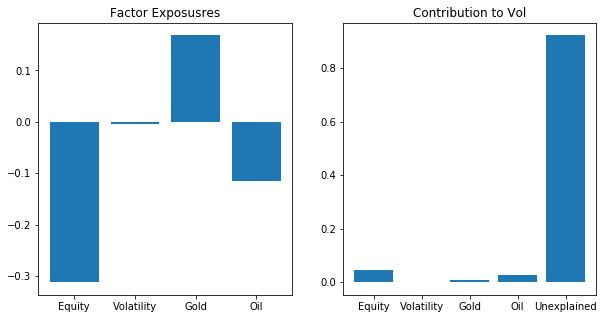

In [13]:
marketcols = marketdata.columns[1:5]
N = len(marketcols)
hcols = marketdata.columns[5:N-1]
xdata = marketdata[marketcols]
model = sm.OLS(fund,xdata)
fit = model.fit()
betas = fit.params
N = len(betas)
criskmod,labels = hf.factor_risk_attrib(fit,xdata, marketcols)

f, ax = plt.subplots(figsize=(10, 5))
plt.subplot(1,2,1)

plt.bar(np.arange(N),betas)
plt.xticks(np.arange(N),marketcols)
plt.title('Factor Exposusres')
plt.subplot(1,2,2)


plt.title('Contribution to Vol')
plt.bar(np.arange(N+1),criskmod)
plt.xticks(np.arange(N+1),labels)

The large unexplained part in Contribution to Vol chart shows that the fund's strategy may be uncorrelated to major risk factors.

<h2>Peer Analysis</h2>

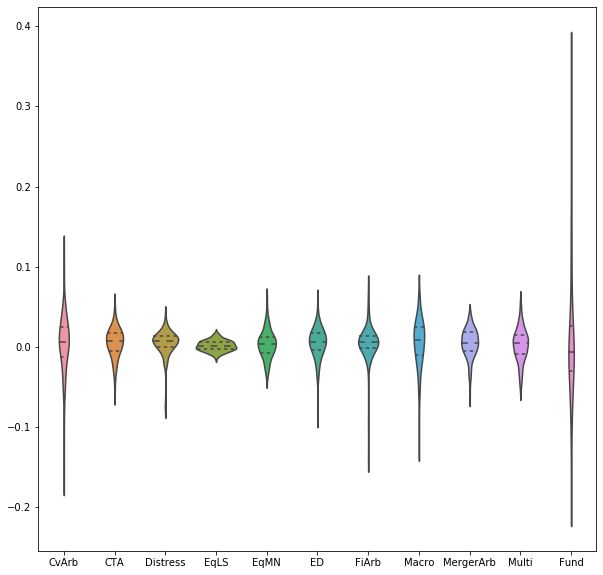

In [14]:
import seaborn as sns
N = len(marketdata.columns)
hfcols = marketdata.columns[6:N-1]
hfcols = np.append(hfcols,['Fund'])
hfdata = marketdata[hfcols]
f, ax = plt.subplots(figsize=(10,10))
sns.violinplot(data=hfdata,vert=False,split=True, inner="quartile")

<h2>Correlations</h2>
<article>.
The following chart shows correlation among hedge fund strategies. Similar analysis can performed on individual funds.</article>

C:\Users\amati\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


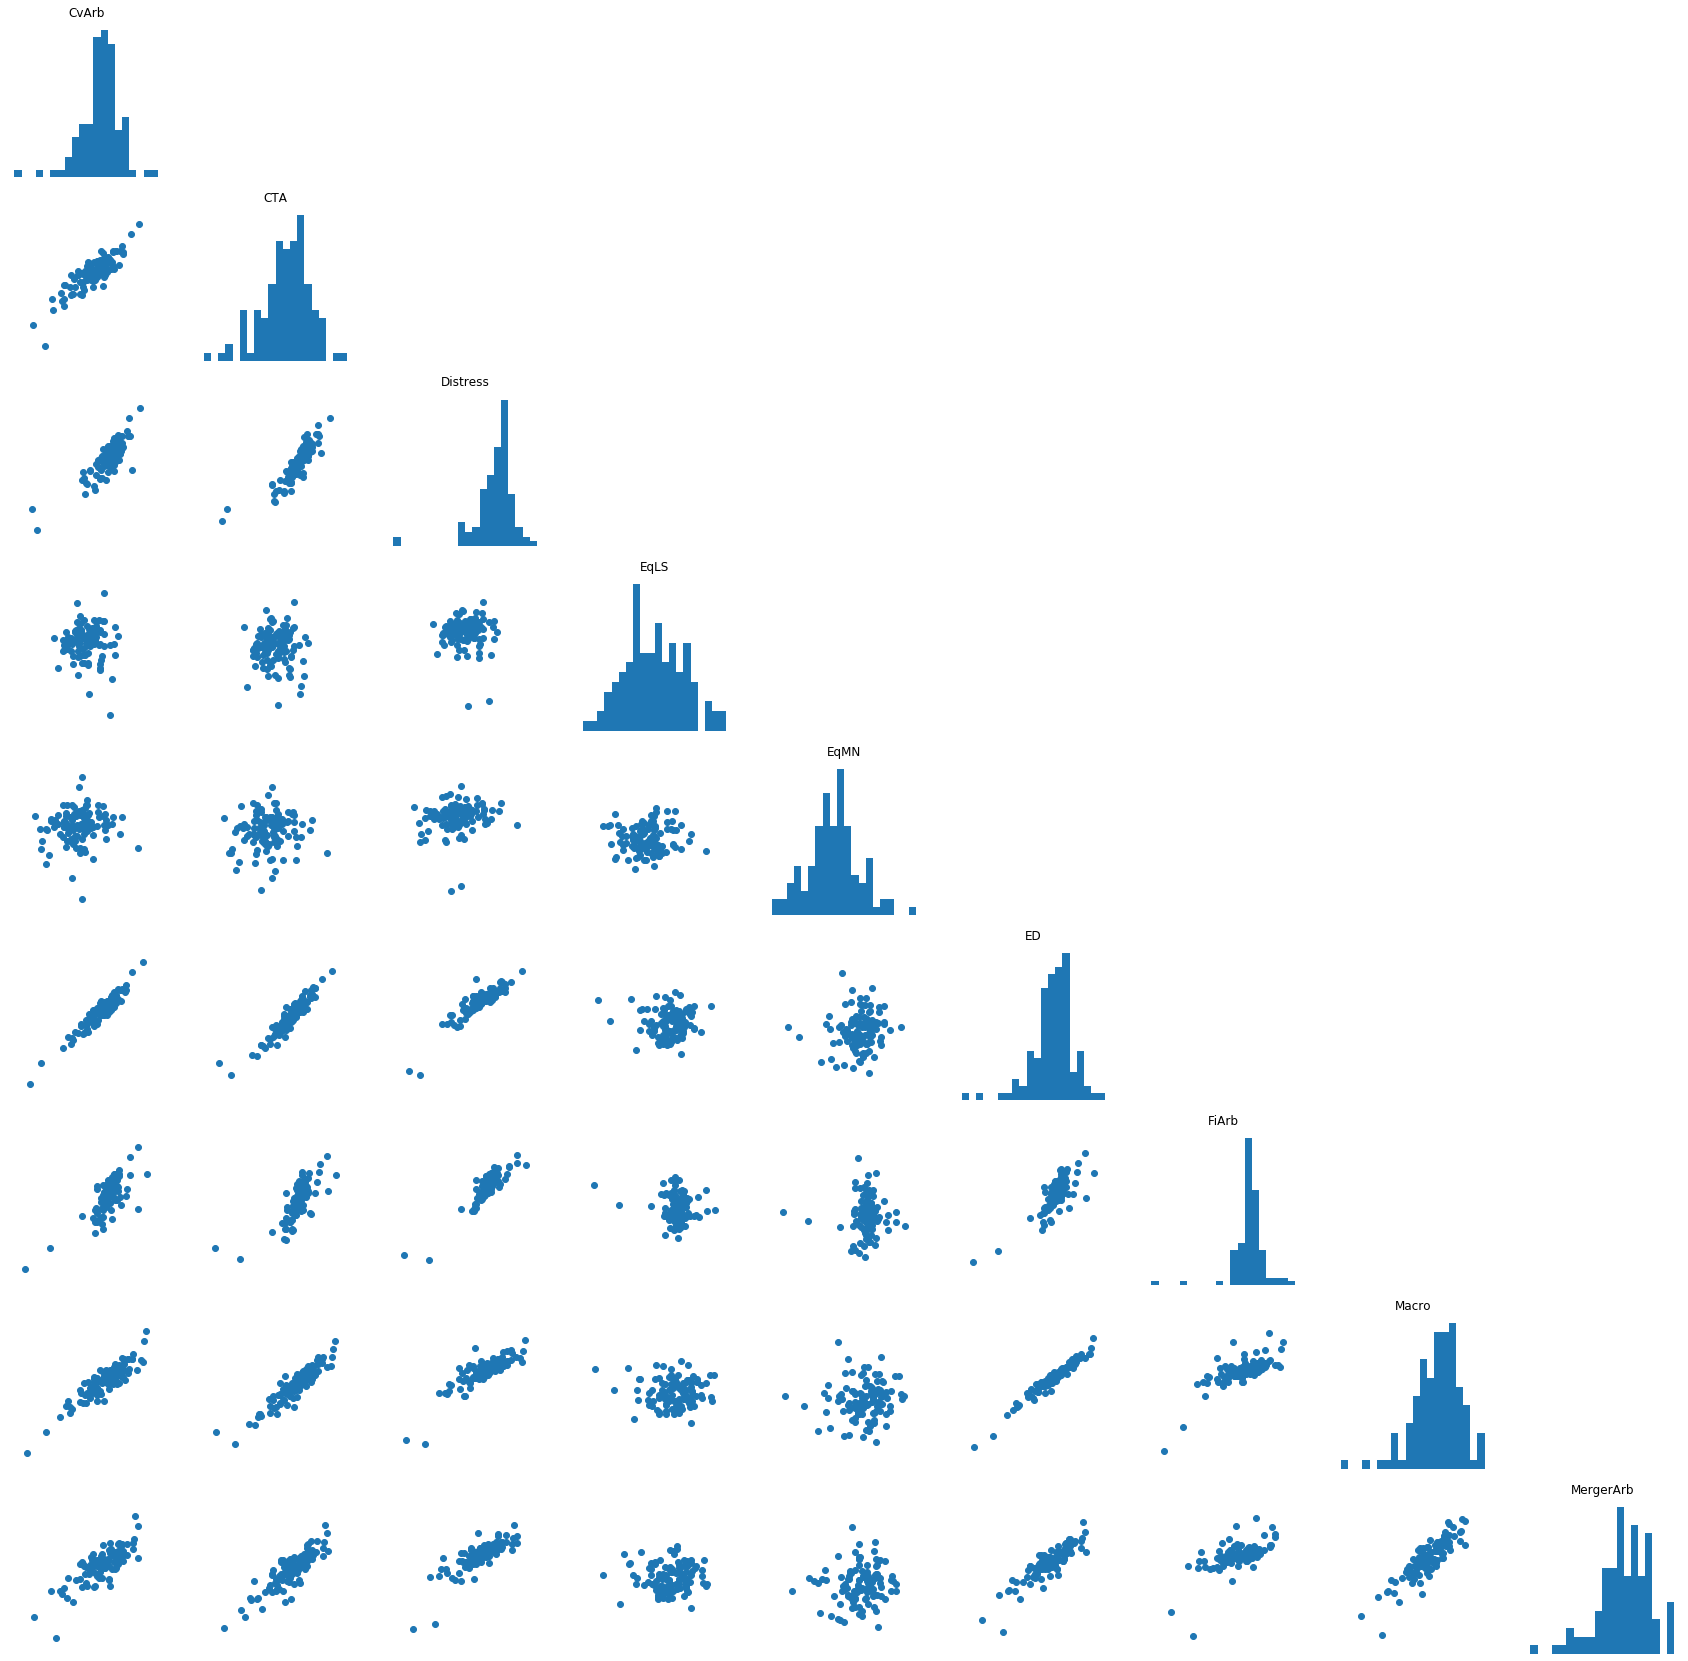

In [16]:
f, ax = plt.subplots(figsize=(30, 30))
cols = hfdata.columns
#len(hfdata.columns)
N = 9
for i in range(0,N):
    fa = hfdata.iloc[:,i]
    for j in range(0,i+1):
        
        fb = hfdata.iloc[:,j]
        idx = i * N + j+1
        if i == j:
            x = 1
            plt.subplot(N,N,idx)
            n, bins, patches = pl.hist(fa, 20, normed=1, histtype='stepfilled')
            y = norm.pdf(bins, mu, sigma)
            plt.title(cols[i])
            plt.axis('off')
        
        else:
            plt.subplot(N,N,idx)
            plt.scatter(fa,fb)
            plt.axis('off')
            

<H2>Correlation Matrix</H2>

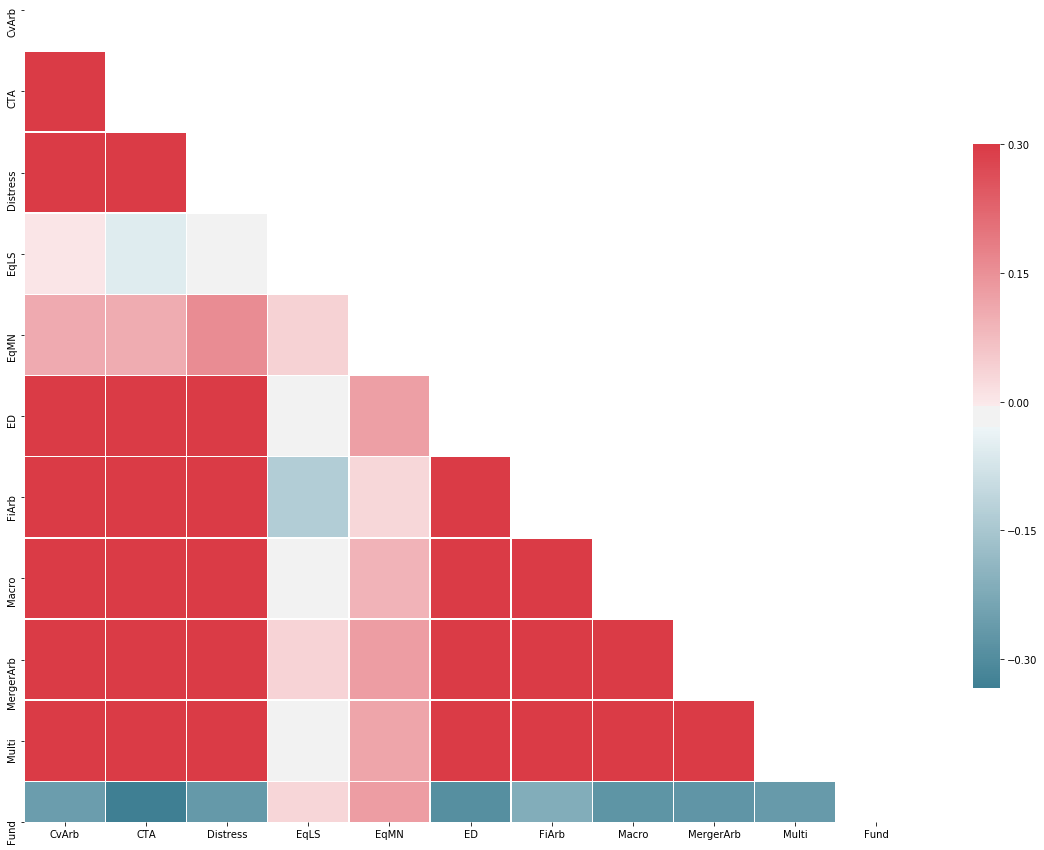

In [17]:
corr = hfdata.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

<H2>Non-Linear Analysis</H2>
<article>
Non-Linear Analysis tried to identify how the fund would react due to large movements in one or more market benchmarks. We perform such analysis with respect to equity benchmark. The results are shown in the scatter plot where the green line represents the convexity fit of data. The model is based on Treynor-Mazuy market timing model.
</article>

Text(0.5, 1.0, 'Convexity Analysis vs. Equity')

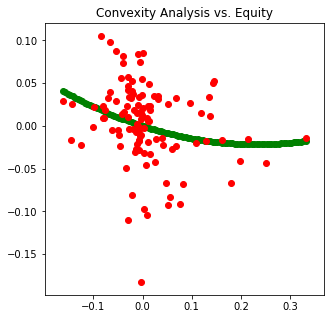

In [18]:
import statsmodels as sm
cv = hf.convexity_analysis(tsdata,'Fund','Equity')
f, ax = plt.subplots(figsize=(5, 5))
plt.scatter(cv['xhat'],cv['yhat'],color='g')
plt.scatter(cv['x'],cv['y'],color='r')
plt.title ('Convexity Analysis vs. Equity')

<h2>Stress Tests</h2>
Non-Linear Profile (such as the smile shown above) imply that the fund should perform well during large shocks to the benchmark.
We can now have the shocks applied to all market factors

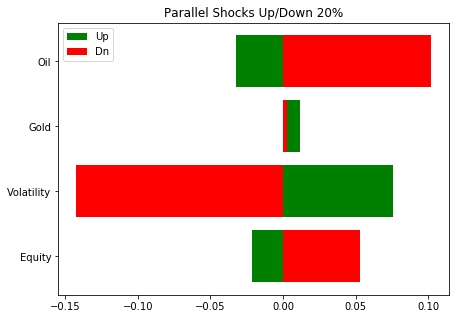

In [19]:
marketfactors = ['Equity', 'Volatility', 'Gold', 'Oil']
shocksup = np.zeros(4)
shocksdn = np.zeros(4)
shock = 0.20
ssq = 0.2*0.2
for [f,i] in zip(marketfactors,range(4)):
    cv = hf.convexity_analysis(tsdata,'Fund',f)
    b1 = cv['betas'][0]
    b2 = cv['betas'][1]
    shocksup[i] = b1*shock + b2 * ssq
    shocksdn[i] = b1*shock*-1 + b2 * ssq

f, ax = plt.subplots(figsize=(7, 5))
plt.barh(np.array(range(4)),shocksup,color='g')
plt.barh(np.array(range(4)),shocksdn,color='r')

plt.yticks([0,1,2,3],marketfactors)
plt.title("Parallel Shocks Up/Down 20%")
plt.legend(['Up','Dn'])



<h2>Conclusion</h2>
The above example provide a small sample of analysis that can be performed using just monthly time series data. More detailed analysis can be performed by combining monthly data with holdings or exposure data. Send email to hedgfundriskguy@yahoo.com for more information. 